# 0. Introduction

One hundred Chinese nationals took part in data collection. 

Each participant wrote with a standard black ink pen all 15 numbers in a table with 15 designated regions drawn on a white A4 paper. 

This process was repeated 10 times with each participant. Each sheet was scanned at the resolution of 300x300 pixels.

# 1. Package Initialization

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report

from skimage.io import imread, imshow

from collections import defaultdict
from glob import glob
import math, re


"""
    Math Plot Library Configs
"""

%matplotlib inline
mpl.style.use('seaborn')
mpl.rcParams["figure.facecolor"] ='#f6f5f5'

"""
    Pandas Configs
"""

# show all columns
# pd.set_option('max_columns', None)

# show all rows
pd.set_option("max_rows", None)

# Whether to print out the full DataFrame repr for wide DataFrames across multiple lines, 
# max_columns is still respected, but the output will wrap-around across multiple “pages” 
# if it’s width exceeds display.width. [default: True] [currently: True]
pd.set_option('display.expand_frame_repr', False)


"""
    Seaborn Configs
"""
sns.set_palette("pastel")

# 2. Data Preparation

First and foremost, we would have to import the labels of the images from the filename to the Panda dataframe, so that we can train our Neural Network.

However, before we start creating the labels, let us look at all of the possible labels:

<img src="../characters_mapping.png" alt="MNIST Chinese Character Mapping" width="250px" align="left"/>

## a. Sample Data

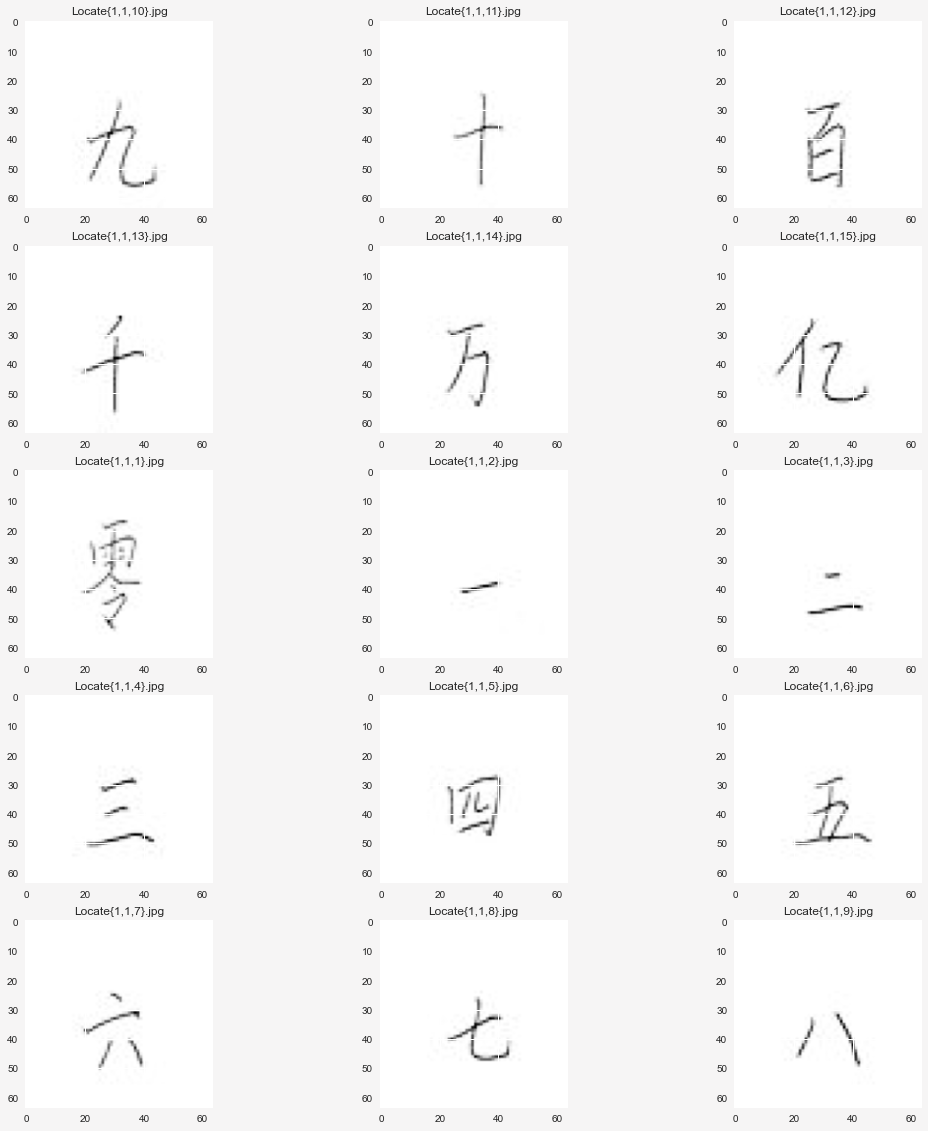

In [2]:
FIRST_N_ROWS = 15
NUMBER_OF_IMG_PER_ROWS = 5

filepaths = sorted(glob('../raw_dataset/*.jpg'))
truncated_filepaths = filepaths[:FIRST_N_ROWS]

rows_no = 1 * NUMBER_OF_IMG_PER_ROWS
cols_no = math.ceil(len(truncated_filepaths) / NUMBER_OF_IMG_PER_ROWS)
fig, axis = plt.subplots(
    rows_no , 
    cols_no , 
    figsize=(18,20)
)

for img_path, axis in zip(truncated_filepaths, axis.flatten()):
    axis.imshow(imread(img_path))
    axis.set_title(img_path.split('/')[-1])

## b. Convert Image and its Metadata into Labels and Panda Dataframe

In [3]:
# return list: [img_idx, pixel_1, ..., pixel_4096, label]
def build_col_names(ROW_IN_PIXEL, COL_IN_PIXEL):
    col_names = []
    for i in range(ROW_IN_PIXEL * COL_IN_PIXEL):
        col_names.append(f'pixel_{i+1}')
    col_names.append('img_idxs')
    col_names.append('character')
    col_names.append('label')
    return col_names

# format: Locate{person_no, repeat_no, label}.jpg
def get_label_from_path(img_path):
    filename = img_path.split('/')[-1]
    matching_str = re.search(r"\{[\w,]+\}", filename)
    cleaned_matching_str = matching_str.group(0).replace('{', '').replace('}', '')
    label = cleaned_matching_str.split(',')[-1]
    return label

def vectorize_image_into_1d_array(img_path):
    img = plt.imread(img_path)
    rows, cols = img.shape # gives dimensions for BW array
    img_size = rows*cols
    img_1D_vector = img.reshape(img_size)
    return img_1D_vector

In [4]:
ROW_IN_PIXEL = 64
COL_IN_PIXEL = 64
COL_NAMES = build_col_names(ROW_IN_PIXEL, COL_IN_PIXEL)

CHARACTER_LABEL_MAPPING = {
    '1': "零",
    '2': "一",
    '3': "二",
    '4': "三",
    '5': "四",
    '6': "五",
    '7': "六",
    '8': "七",
    '9': "八",
    '10': "九",
    '11': "十",
    '12': "百",
    '13': "千",
    '14': "萬",
    '15': "億"
}

In [5]:
data = []

for img_idx, img_path in enumerate(filepaths):
    temp = []
    
    img_1D_vector = vectorize_image_into_1d_array(img_path)
    temp.extend(img_1D_vector)
    
    label = get_label_from_path(img_path)
    temp.append(img_idx)
    temp.append(CHARACTER_LABEL_MAPPING[label])
    temp.append(label)
    
    data.append(temp)
    
df = pd.DataFrame(data, columns = COL_NAMES)
display(df.head())

,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,...,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,pixel_4096,img_idxs,character,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,九,10
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,十,11
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,百,12
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,千,13
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,萬,14


# Neural Network

## Neural Network Architecture

<!-- <img src="./img/iris_relu.png" alt="Rectified Linear Unit - ReLu" width="500px" align="left"/> -->
<img src="./img/MNIST_Chinese_Neural_Network.png" alt="Neural Network Architecture" width="450px" align="center">

### Cost Function
$$
\mathcal{L} = -[ylog\hat y + (1-y)log(1-y^{T})]
$$

### Activation Function
$$
\sigma(z) = g_{ReLU}(z) = max(0, z) \\
g_{softmax(z)} = \dfrac{e^{z_{i}}}{\sum^{K}_{j=1}e^{z_{j}}}
$$

## Forward Propagation

### Dimension
100 people -> Each person draws 15 drawings -> This is repeated 10x

Total Images: 15.000

### Formula

<div align="center"><b>Input:</b></div>

$$
A0 = x^{T}
$$

<div align="center"><b>Dimensions:</b></div>
$$
x: \text{15000 x 4096} \\
A0: \text{4096 x 15000 } (x^{T})
$$

<br/>

<div align="center"><b>Layer 1:</b></div>
$$
Z1 = W1 \cdot A0 + b1 \\
A1 = g_{ReLU}(Z1) \\
$$

<div align="center"><b>Dimensions:</b></div>
$$
W1: \text{15 x 4096} \\
b1: \text{15 x 1}\\
A1: \text{15 x 15000}
$$

<br />

<div align="center"><b>Layer 2:</b></div>
$$
Z2 = W2 \cdot A1 + b2 \\
\hat y = A2 = g_{softmax}(Z2)
$$

<div align="center"><b>Dimensions:</b></div>
$$
W2: \text{15 x 15} \\
b2: \text{15 x 1}\\
A2: \text{15 x 15000}
$$

In [16]:
def init_params():
    W1 = np.random.rand(15, 4096) - 0.5
    W2 = np.random.rand(15, 15) - 0.5
    
    b1 = np.random.rand(15, 1) - 0.5
    b2 = np.random.rand(15, 1) - 0.5
    
    return W1, b1, W2, b2

def forward_prop(X, W1, b1, W2, b2):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

def ReLU(z):
    return np.maximum(z, 0)
    
def softmax(z):
    exp_vals = 1 / (1 + np.exp(-z)) # to prevent numpy overflow
    return exp_vals / sum(exp_vals)

In [17]:
W1, b1, W2, b2 = init_params()

X = np.transpose(df[COL_NAMES[:4096]]) # ignore the stuffs that we added (e.g. img_idx, character, and label)
Z1, A1, Z2, A2 = forward_prop(X, W1, b1, W2, b2)

<ipython-input-16-0dbea32045b3>:23: RuntimeWarning: overflow encountered in exp
  exp_vals = 1 / (1 + np.exp(-z)) # to prevent numpy overflow


## Backward Propagation

In [15]:
A2

array([[2.26591200e-064, 1.72935974e-047, 7.59313417e-145, ...,
        1.65195176e-001, 1.67713088e-012, 3.25592722e-093],
       [1.42857143e-001, 1.00000588e-001, 8.11336411e-011, ...,
        5.27161071e-042, 1.51939373e-001, 1.19075157e-001],
       [2.02796062e-124, 5.88225167e-032, 1.25000003e-001, ...,
        2.55099983e-033, 2.62287321e-063, 1.19075157e-001],
       ...,
       [1.42857143e-001, 1.00000588e-001, 1.93202391e-072, ...,
        1.53794974e-060, 1.51939373e-001, 2.04485375e-004],
       [3.45121217e-056, 1.00000588e-001, 1.25000003e-001, ...,
        7.73809240e-023, 6.19674627e-030, 1.19075157e-001],
       [1.42857143e-001, 3.14893863e-071, 5.90036934e-112, ...,
        1.66958951e-001, 1.51939373e-001, 1.70880934e-062]])